# Metric

In [4]:
m = tf.keras.metrics.Accuracy() 
_ = m.update_state([1, 2, 3, 4], [0, 2, 3, 4]) 

print(m.result().numpy()) 

#m.reset_states() 

_ = m.update_state([1, 2, 3, 4], [0, 2, 3, 4], 
                    sample_weight=[1, 1, 0, 0]) 
print(m.result().numpy()) 


0.75
0.5


In [7]:
m = tf.keras.metrics.CategoricalAccuracy() 
_ = m.update_state([[0, 0, 1], [0, 1, 0]], [[0.1, 0.9, 0.8], 
                    [0.05, 0.95, 0]]) 
print(m.result().numpy()) 

#m.reset_states() 

_ = m.update_state([[0, 1,0], [0, 1, 0]], [[0.1, 0.9, 0.8], 
                    [0.05, 0.95, 0]]) 
print(m.result().numpy()) 

0.5
1.0


In [10]:
m = tf.keras.metrics.SparseCategoricalAccuracy() 
_ = m.update_state([[2], [1]], [[0.1, 0.9, 0.8], [0.05, 0.95, 0]]) 

print(m.result().numpy())

#m.reset_states() 

_ = m.update_state([[0], [0]], [[0.1, 0.9, 0.8], [0.05, 0.95, 0]]) 
print(m.result().numpy())

0.5
0.25


In [11]:
m = tf.keras.metrics.CategoricalCrossentropy()
m.update_state([[0, 1, 0], [0, 0, 1]],
               [[0.05, 0.95, 0], [0.1, 0.8, 0.1]])
'''
# EPSILON = 1e-7, y = y_true, y` = y_pred
# y` = clip_ops.clip_by_value(output, EPSILON, 1. - EPSILON)
# y` = [[0.05, 0.95, EPSILON], [0.1, 0.8, 0.1]]

# xent = -sum(y * log(y'), axis = -1)
#      = ((-log 0.95), (-log 0.1))
#      = [0.051, 2.302]
# Reduced mean = (0.051 + 2.302) / 2
'''
print(m.result().numpy()) 


#m.reset_states() 

m.update_state([[0, 1, 0], [0, 1, 0]],
               [[0.05, 0.95, 0], [0.1, 0.8, 0.1]])

print(m.result().numpy()) 

1.1769392
0.65707886


In [14]:
m = tf.keras.metrics.SparseCategoricalCrossentropy()
m.update_state(
  [1, 2],
  [[0.05, 0.95, 0], [0.1, 0.8, 0.1]])

print(m.result().numpy())  

#m.reset_states() 

m.update_state(
  [0, 0],
  [[0.05, 0.95, 0], [0.1, 0.8, 0.1]])

print(m.result().numpy())  

1.1769392
1.913049


# DNN神經網路訓練及驗證 

In [1]:
import numpy as np
import tensorflow as tf
tf.compat.v1.reset_default_graph()
class MNISTLoader():
    def __init__(self):
        mnist = tf.keras.datasets.mnist
        (self.train_data, self.train_label), (self.test_data, self.test_label) = mnist.load_data()

        self.train_data = np.expand_dims(self.train_data.astype(np.float32) / 255.0, axis=-1)      # [60000, 28, 28, 1]
        self.test_data = np.expand_dims(self.test_data.astype(np.float32) / 255.0, axis=-1)        # [10000, 28, 28, 1]
        self.train_label = self.train_label.astype(np.int32)    # [60000]
        self.test_label = self.test_label.astype(np.int32)      # [10000]
        self.num_train_data, self.num_test_data = self.train_data.shape[0], self.test_data.shape[0]

    def get_batch(self, batch_size):

        index = np.random.randint(0, self.num_train_data, batch_size)
        return self.train_data[index, :], self.train_label[index]
    
class MLP(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.flatten = tf.keras.layers.Flatten()    # Flatten层将除第一维（batch_size）以外的维度展平
        self.dense1 = tf.keras.layers.Dense(units=100, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(units=10)

    def call(self, inputs):         # [batch_size, 28, 28, 1]
        x = self.flatten(inputs)    # [batch_size, 784]
        x = self.dense1(x)          # [batch_size, 100]
        x = self.dense2(x)          # [batch_size, 10]
        output = tf.nn.softmax(x)
        return output

num_epochs = 5
batch_size = 50
learning_rate = 0.001

model = MLP()
data_loader = MNISTLoader()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

num_batches = int(data_loader.num_train_data // batch_size * num_epochs)
for batch_index in range(num_batches):
    X, y = data_loader.get_batch(batch_size)
    with tf.GradientTape() as tape:
        y_pred = model(X)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=y, y_pred=y_pred)
        loss = tf.reduce_mean(loss)
        print("batch %d: loss %f" % (batch_index, loss.numpy()))
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
    

sparse_categorical_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
num_batches = int(data_loader.num_test_data // batch_size)
for batch_index in range(num_batches):
    start_index, end_index = batch_index * batch_size, (batch_index + 1) * batch_size
    y_pred = model.predict(data_loader.test_data[start_index: end_index])
    sparse_categorical_accuracy.update_state(y_true=data_loader.test_label[start_index: end_index], y_pred=y_pred)
print("test accuracy: %f" % sparse_categorical_accuracy.result())

batch 0: loss 2.354974
batch 1: loss 2.284669
batch 2: loss 2.218428
batch 3: loss 2.188677
batch 4: loss 2.051362
batch 5: loss 1.954491
batch 6: loss 2.010463
batch 7: loss 1.823143
batch 8: loss 1.834284
batch 9: loss 1.857236
batch 10: loss 1.733362
batch 11: loss 1.747833
batch 12: loss 1.549515
batch 13: loss 1.496554
batch 14: loss 1.487920
batch 15: loss 1.547255
batch 16: loss 1.440515
batch 17: loss 1.393875
batch 18: loss 1.277772
batch 19: loss 1.475433
batch 20: loss 1.328399
batch 21: loss 1.254127
batch 22: loss 1.189001
batch 23: loss 1.021514
batch 24: loss 1.149965
batch 25: loss 1.097938
batch 26: loss 1.171792
batch 27: loss 0.985283
batch 28: loss 1.133463
batch 29: loss 1.090808
batch 30: loss 0.809829
batch 31: loss 0.989750
batch 32: loss 0.813451
batch 33: loss 0.785609
batch 34: loss 0.863971
batch 35: loss 0.881977
batch 36: loss 0.879459
batch 37: loss 0.622087
batch 38: loss 0.813776
batch 39: loss 0.702438
batch 40: loss 0.749615
batch 41: loss 0.796997
ba

batch 346: loss 0.370000
batch 347: loss 0.312630
batch 348: loss 0.291699
batch 349: loss 0.207417
batch 350: loss 0.369015
batch 351: loss 0.221622
batch 352: loss 0.223978
batch 353: loss 0.421958
batch 354: loss 0.210544
batch 355: loss 0.412597
batch 356: loss 0.258187
batch 357: loss 0.292473
batch 358: loss 0.213100
batch 359: loss 0.157366
batch 360: loss 0.342251
batch 361: loss 0.294321
batch 362: loss 0.177613
batch 363: loss 0.157225
batch 364: loss 0.316996
batch 365: loss 0.342151
batch 366: loss 0.291449
batch 367: loss 0.516263
batch 368: loss 0.311859
batch 369: loss 0.442579
batch 370: loss 0.216022
batch 371: loss 0.425467
batch 372: loss 0.106068
batch 373: loss 0.347413
batch 374: loss 0.232258
batch 375: loss 0.260568
batch 376: loss 0.399738
batch 377: loss 0.377000
batch 378: loss 0.180393
batch 379: loss 0.260714
batch 380: loss 0.385250
batch 381: loss 0.336319
batch 382: loss 0.338826
batch 383: loss 0.280164
batch 384: loss 0.349495
batch 385: loss 0.149280


batch 684: loss 0.185845
batch 685: loss 0.172178
batch 686: loss 0.180075
batch 687: loss 0.110639
batch 688: loss 0.214267
batch 689: loss 0.091975
batch 690: loss 0.122914
batch 691: loss 0.156976
batch 692: loss 0.421308
batch 693: loss 0.254533
batch 694: loss 0.181864
batch 695: loss 0.063782
batch 696: loss 0.073115
batch 697: loss 0.217698
batch 698: loss 0.162939
batch 699: loss 0.221288
batch 700: loss 0.123307
batch 701: loss 0.198036
batch 702: loss 0.062792
batch 703: loss 0.088096
batch 704: loss 0.260044
batch 705: loss 0.267470
batch 706: loss 0.161040
batch 707: loss 0.155489
batch 708: loss 0.075494
batch 709: loss 0.318256
batch 710: loss 0.181334
batch 711: loss 0.267374
batch 712: loss 0.141915
batch 713: loss 0.240593
batch 714: loss 0.210442
batch 715: loss 0.301391
batch 716: loss 0.243376
batch 717: loss 0.162683
batch 718: loss 0.223502
batch 719: loss 0.250063
batch 720: loss 0.196407
batch 721: loss 0.146566
batch 722: loss 0.202879
batch 723: loss 0.192433


batch 1022: loss 0.079797
batch 1023: loss 0.149820
batch 1024: loss 0.325003
batch 1025: loss 0.138606
batch 1026: loss 0.118375
batch 1027: loss 0.144403
batch 1028: loss 0.102640
batch 1029: loss 0.236083
batch 1030: loss 0.071915
batch 1031: loss 0.085338
batch 1032: loss 0.053681
batch 1033: loss 0.065566
batch 1034: loss 0.193237
batch 1035: loss 0.095986
batch 1036: loss 0.135531
batch 1037: loss 0.101196
batch 1038: loss 0.262739
batch 1039: loss 0.269792
batch 1040: loss 0.107781
batch 1041: loss 0.281506
batch 1042: loss 0.019244
batch 1043: loss 0.181595
batch 1044: loss 0.080537
batch 1045: loss 0.057033
batch 1046: loss 0.130381
batch 1047: loss 0.132931
batch 1048: loss 0.164143
batch 1049: loss 0.157836
batch 1050: loss 0.064536
batch 1051: loss 0.269267
batch 1052: loss 0.157283
batch 1053: loss 0.122124
batch 1054: loss 0.099034
batch 1055: loss 0.214776
batch 1056: loss 0.271808
batch 1057: loss 0.151808
batch 1058: loss 0.131906
batch 1059: loss 0.218510
batch 1060: 

batch 1357: loss 0.097024
batch 1358: loss 0.327961
batch 1359: loss 0.271296
batch 1360: loss 0.065213
batch 1361: loss 0.109159
batch 1362: loss 0.149694
batch 1363: loss 0.132359
batch 1364: loss 0.159941
batch 1365: loss 0.338057
batch 1366: loss 0.143690
batch 1367: loss 0.138126
batch 1368: loss 0.140219
batch 1369: loss 0.144624
batch 1370: loss 0.137077
batch 1371: loss 0.228258
batch 1372: loss 0.151209
batch 1373: loss 0.116681
batch 1374: loss 0.205639
batch 1375: loss 0.162341
batch 1376: loss 0.144972
batch 1377: loss 0.233726
batch 1378: loss 0.256713
batch 1379: loss 0.117442
batch 1380: loss 0.131154
batch 1381: loss 0.202371
batch 1382: loss 0.167288
batch 1383: loss 0.061871
batch 1384: loss 0.115307
batch 1385: loss 0.305838
batch 1386: loss 0.024907
batch 1387: loss 0.127639
batch 1388: loss 0.129598
batch 1389: loss 0.083454
batch 1390: loss 0.118064
batch 1391: loss 0.185637
batch 1392: loss 0.200854
batch 1393: loss 0.192245
batch 1394: loss 0.208101
batch 1395: 

batch 1690: loss 0.241091
batch 1691: loss 0.056262
batch 1692: loss 0.053080
batch 1693: loss 0.083063
batch 1694: loss 0.119164
batch 1695: loss 0.067520
batch 1696: loss 0.029850
batch 1697: loss 0.151135
batch 1698: loss 0.154548
batch 1699: loss 0.254188
batch 1700: loss 0.250771
batch 1701: loss 0.028574
batch 1702: loss 0.039886
batch 1703: loss 0.204351
batch 1704: loss 0.154442
batch 1705: loss 0.221737
batch 1706: loss 0.273470
batch 1707: loss 0.192523
batch 1708: loss 0.119498
batch 1709: loss 0.115590
batch 1710: loss 0.123084
batch 1711: loss 0.097932
batch 1712: loss 0.150834
batch 1713: loss 0.076623
batch 1714: loss 0.104476
batch 1715: loss 0.110978
batch 1716: loss 0.155764
batch 1717: loss 0.061334
batch 1718: loss 0.035091
batch 1719: loss 0.285435
batch 1720: loss 0.062327
batch 1721: loss 0.101380
batch 1722: loss 0.218172
batch 1723: loss 0.124555
batch 1724: loss 0.344617
batch 1725: loss 0.117195
batch 1726: loss 0.062393
batch 1727: loss 0.078101
batch 1728: 

batch 2014: loss 0.077986
batch 2015: loss 0.033786
batch 2016: loss 0.073165
batch 2017: loss 0.125136
batch 2018: loss 0.022333
batch 2019: loss 0.241528
batch 2020: loss 0.285413
batch 2021: loss 0.038389
batch 2022: loss 0.086380
batch 2023: loss 0.211836
batch 2024: loss 0.167577
batch 2025: loss 0.167371
batch 2026: loss 0.080038
batch 2027: loss 0.052342
batch 2028: loss 0.052427
batch 2029: loss 0.117528
batch 2030: loss 0.044624
batch 2031: loss 0.179115
batch 2032: loss 0.084399
batch 2033: loss 0.081627
batch 2034: loss 0.102387
batch 2035: loss 0.044944
batch 2036: loss 0.027815
batch 2037: loss 0.061527
batch 2038: loss 0.044473
batch 2039: loss 0.140294
batch 2040: loss 0.221369
batch 2041: loss 0.079355
batch 2042: loss 0.061175
batch 2043: loss 0.157340
batch 2044: loss 0.180752
batch 2045: loss 0.052998
batch 2046: loss 0.038037
batch 2047: loss 0.128735
batch 2048: loss 0.116784
batch 2049: loss 0.122239
batch 2050: loss 0.198094
batch 2051: loss 0.247445
batch 2052: 

batch 2343: loss 0.148343
batch 2344: loss 0.068670
batch 2345: loss 0.026190
batch 2346: loss 0.109798
batch 2347: loss 0.112895
batch 2348: loss 0.127004
batch 2349: loss 0.086230
batch 2350: loss 0.043898
batch 2351: loss 0.065813
batch 2352: loss 0.095528
batch 2353: loss 0.110921
batch 2354: loss 0.124681
batch 2355: loss 0.120023
batch 2356: loss 0.074536
batch 2357: loss 0.190580
batch 2358: loss 0.100361
batch 2359: loss 0.079969
batch 2360: loss 0.077012
batch 2361: loss 0.056435
batch 2362: loss 0.088743
batch 2363: loss 0.199812
batch 2364: loss 0.018364
batch 2365: loss 0.152741
batch 2366: loss 0.145925
batch 2367: loss 0.054700
batch 2368: loss 0.072773
batch 2369: loss 0.125325
batch 2370: loss 0.057196
batch 2371: loss 0.041700
batch 2372: loss 0.191131
batch 2373: loss 0.018224
batch 2374: loss 0.055630
batch 2375: loss 0.077755
batch 2376: loss 0.153765
batch 2377: loss 0.102269
batch 2378: loss 0.126227
batch 2379: loss 0.114110
batch 2380: loss 0.219170
batch 2381: 

batch 2686: loss 0.193357
batch 2687: loss 0.072512
batch 2688: loss 0.037051
batch 2689: loss 0.230602
batch 2690: loss 0.129437
batch 2691: loss 0.036353
batch 2692: loss 0.056784
batch 2693: loss 0.077109
batch 2694: loss 0.017400
batch 2695: loss 0.037842
batch 2696: loss 0.064757
batch 2697: loss 0.276987
batch 2698: loss 0.028605
batch 2699: loss 0.058248
batch 2700: loss 0.182365
batch 2701: loss 0.045069
batch 2702: loss 0.028862
batch 2703: loss 0.018976
batch 2704: loss 0.059971
batch 2705: loss 0.061567
batch 2706: loss 0.083826
batch 2707: loss 0.078465
batch 2708: loss 0.068854
batch 2709: loss 0.062367
batch 2710: loss 0.116384
batch 2711: loss 0.218252
batch 2712: loss 0.118222
batch 2713: loss 0.027409
batch 2714: loss 0.120208
batch 2715: loss 0.051266
batch 2716: loss 0.071235
batch 2717: loss 0.073107
batch 2718: loss 0.068530
batch 2719: loss 0.033432
batch 2720: loss 0.050853
batch 2721: loss 0.057781
batch 2722: loss 0.057664
batch 2723: loss 0.092228
batch 2724: 

batch 3023: loss 0.244572
batch 3024: loss 0.167608
batch 3025: loss 0.139939
batch 3026: loss 0.030579
batch 3027: loss 0.020265
batch 3028: loss 0.062796
batch 3029: loss 0.045857
batch 3030: loss 0.034191
batch 3031: loss 0.086906
batch 3032: loss 0.033416
batch 3033: loss 0.206384
batch 3034: loss 0.146306
batch 3035: loss 0.106029
batch 3036: loss 0.039111
batch 3037: loss 0.118765
batch 3038: loss 0.106163
batch 3039: loss 0.014272
batch 3040: loss 0.026002
batch 3041: loss 0.090110
batch 3042: loss 0.028876
batch 3043: loss 0.049487
batch 3044: loss 0.061588
batch 3045: loss 0.026173
batch 3046: loss 0.027316
batch 3047: loss 0.099431
batch 3048: loss 0.270686
batch 3049: loss 0.053344
batch 3050: loss 0.056869
batch 3051: loss 0.152664
batch 3052: loss 0.022791
batch 3053: loss 0.083684
batch 3054: loss 0.143906
batch 3055: loss 0.032524
batch 3056: loss 0.135060
batch 3057: loss 0.074722
batch 3058: loss 0.096699
batch 3059: loss 0.025599
batch 3060: loss 0.048137
batch 3061: 

batch 3348: loss 0.036646
batch 3349: loss 0.013443
batch 3350: loss 0.160181
batch 3351: loss 0.041052
batch 3352: loss 0.094571
batch 3353: loss 0.018829
batch 3354: loss 0.050475
batch 3355: loss 0.153668
batch 3356: loss 0.043831
batch 3357: loss 0.026228
batch 3358: loss 0.025341
batch 3359: loss 0.022870
batch 3360: loss 0.175371
batch 3361: loss 0.135083
batch 3362: loss 0.090149
batch 3363: loss 0.022551
batch 3364: loss 0.045861
batch 3365: loss 0.014583
batch 3366: loss 0.057841
batch 3367: loss 0.053545
batch 3368: loss 0.041294
batch 3369: loss 0.165157
batch 3370: loss 0.147391
batch 3371: loss 0.061292
batch 3372: loss 0.040104
batch 3373: loss 0.052816
batch 3374: loss 0.052282
batch 3375: loss 0.104870
batch 3376: loss 0.172330
batch 3377: loss 0.011281
batch 3378: loss 0.043427
batch 3379: loss 0.119777
batch 3380: loss 0.010174
batch 3381: loss 0.103678
batch 3382: loss 0.036479
batch 3383: loss 0.098519
batch 3384: loss 0.013362
batch 3385: loss 0.052988
batch 3386: 

batch 3674: loss 0.145214
batch 3675: loss 0.053647
batch 3676: loss 0.045171
batch 3677: loss 0.076034
batch 3678: loss 0.077588
batch 3679: loss 0.081294
batch 3680: loss 0.053183
batch 3681: loss 0.086149
batch 3682: loss 0.111082
batch 3683: loss 0.153498
batch 3684: loss 0.218930
batch 3685: loss 0.132574
batch 3686: loss 0.114169
batch 3687: loss 0.127728
batch 3688: loss 0.018451
batch 3689: loss 0.046050
batch 3690: loss 0.082012
batch 3691: loss 0.042633
batch 3692: loss 0.065710
batch 3693: loss 0.129600
batch 3694: loss 0.090681
batch 3695: loss 0.039357
batch 3696: loss 0.057671
batch 3697: loss 0.021876
batch 3698: loss 0.086130
batch 3699: loss 0.048604
batch 3700: loss 0.021875
batch 3701: loss 0.028216
batch 3702: loss 0.108014
batch 3703: loss 0.035713
batch 3704: loss 0.028260
batch 3705: loss 0.056517
batch 3706: loss 0.045610
batch 3707: loss 0.046301
batch 3708: loss 0.030747
batch 3709: loss 0.063218
batch 3710: loss 0.075246
batch 3711: loss 0.058846
batch 3712: 

batch 4025: loss 0.032211
batch 4026: loss 0.034158
batch 4027: loss 0.135351
batch 4028: loss 0.025127
batch 4029: loss 0.102032
batch 4030: loss 0.008494
batch 4031: loss 0.074862
batch 4032: loss 0.069110
batch 4033: loss 0.020872
batch 4034: loss 0.016223
batch 4035: loss 0.185478
batch 4036: loss 0.085164
batch 4037: loss 0.042510
batch 4038: loss 0.029293
batch 4039: loss 0.093906
batch 4040: loss 0.056563
batch 4041: loss 0.116627
batch 4042: loss 0.072881
batch 4043: loss 0.113114
batch 4044: loss 0.025265
batch 4045: loss 0.037751
batch 4046: loss 0.043395
batch 4047: loss 0.010222
batch 4048: loss 0.052541
batch 4049: loss 0.069543
batch 4050: loss 0.116998
batch 4051: loss 0.073339
batch 4052: loss 0.030252
batch 4053: loss 0.027141
batch 4054: loss 0.043177
batch 4055: loss 0.008752
batch 4056: loss 0.073324
batch 4057: loss 0.041622
batch 4058: loss 0.071492
batch 4059: loss 0.027536
batch 4060: loss 0.019765
batch 4061: loss 0.063625
batch 4062: loss 0.084696
batch 4063: 

batch 4347: loss 0.029416
batch 4348: loss 0.057020
batch 4349: loss 0.115522
batch 4350: loss 0.022944
batch 4351: loss 0.019583
batch 4352: loss 0.112000
batch 4353: loss 0.039768
batch 4354: loss 0.088347
batch 4355: loss 0.078006
batch 4356: loss 0.051527
batch 4357: loss 0.031524
batch 4358: loss 0.077274
batch 4359: loss 0.052951
batch 4360: loss 0.087340
batch 4361: loss 0.140438
batch 4362: loss 0.076472
batch 4363: loss 0.025485
batch 4364: loss 0.176236
batch 4365: loss 0.020203
batch 4366: loss 0.080142
batch 4367: loss 0.096157
batch 4368: loss 0.037261
batch 4369: loss 0.093870
batch 4370: loss 0.064888
batch 4371: loss 0.120943
batch 4372: loss 0.018174
batch 4373: loss 0.019742
batch 4374: loss 0.071638
batch 4375: loss 0.012353
batch 4376: loss 0.018842
batch 4377: loss 0.182665
batch 4378: loss 0.016771
batch 4379: loss 0.094651
batch 4380: loss 0.034545
batch 4381: loss 0.044476
batch 4382: loss 0.132737
batch 4383: loss 0.032872
batch 4384: loss 0.088424
batch 4385: 

batch 4688: loss 0.010835
batch 4689: loss 0.033721
batch 4690: loss 0.096444
batch 4691: loss 0.040813
batch 4692: loss 0.044528
batch 4693: loss 0.015718
batch 4694: loss 0.042009
batch 4695: loss 0.011851
batch 4696: loss 0.051492
batch 4697: loss 0.167992
batch 4698: loss 0.017238
batch 4699: loss 0.064260
batch 4700: loss 0.022510
batch 4701: loss 0.009709
batch 4702: loss 0.023593
batch 4703: loss 0.015835
batch 4704: loss 0.119046
batch 4705: loss 0.015718
batch 4706: loss 0.039922
batch 4707: loss 0.041163
batch 4708: loss 0.063659
batch 4709: loss 0.011262
batch 4710: loss 0.089558
batch 4711: loss 0.045165
batch 4712: loss 0.192878
batch 4713: loss 0.017082
batch 4714: loss 0.105356
batch 4715: loss 0.069500
batch 4716: loss 0.021483
batch 4717: loss 0.035416
batch 4718: loss 0.136590
batch 4719: loss 0.008785
batch 4720: loss 0.014541
batch 4721: loss 0.126283
batch 4722: loss 0.021651
batch 4723: loss 0.096506
batch 4724: loss 0.029263
batch 4725: loss 0.033943
batch 4726: 

batch 5005: loss 0.051935
batch 5006: loss 0.066690
batch 5007: loss 0.073702
batch 5008: loss 0.064164
batch 5009: loss 0.008883
batch 5010: loss 0.041584
batch 5011: loss 0.119651
batch 5012: loss 0.034572
batch 5013: loss 0.081821
batch 5014: loss 0.079495
batch 5015: loss 0.034668
batch 5016: loss 0.009789
batch 5017: loss 0.035309
batch 5018: loss 0.019712
batch 5019: loss 0.029401
batch 5020: loss 0.016298
batch 5021: loss 0.058716
batch 5022: loss 0.062317
batch 5023: loss 0.019224
batch 5024: loss 0.031702
batch 5025: loss 0.146854
batch 5026: loss 0.026937
batch 5027: loss 0.051618
batch 5028: loss 0.038016
batch 5029: loss 0.020106
batch 5030: loss 0.032176
batch 5031: loss 0.059331
batch 5032: loss 0.077548
batch 5033: loss 0.010147
batch 5034: loss 0.032305
batch 5035: loss 0.061714
batch 5036: loss 0.055271
batch 5037: loss 0.049094
batch 5038: loss 0.020020
batch 5039: loss 0.012534
batch 5040: loss 0.013121
batch 5041: loss 0.039734
batch 5042: loss 0.022150
batch 5043: 

batch 5330: loss 0.138638
batch 5331: loss 0.056260
batch 5332: loss 0.067022
batch 5333: loss 0.099980
batch 5334: loss 0.075328
batch 5335: loss 0.011514
batch 5336: loss 0.034556
batch 5337: loss 0.125911
batch 5338: loss 0.084765
batch 5339: loss 0.052727
batch 5340: loss 0.037836
batch 5341: loss 0.023832
batch 5342: loss 0.020909
batch 5343: loss 0.054654
batch 5344: loss 0.041454
batch 5345: loss 0.066577
batch 5346: loss 0.021023
batch 5347: loss 0.057578
batch 5348: loss 0.009875
batch 5349: loss 0.044495
batch 5350: loss 0.046006
batch 5351: loss 0.032701
batch 5352: loss 0.033488
batch 5353: loss 0.030610
batch 5354: loss 0.026291
batch 5355: loss 0.025432
batch 5356: loss 0.053662
batch 5357: loss 0.012976
batch 5358: loss 0.131215
batch 5359: loss 0.130936
batch 5360: loss 0.015193
batch 5361: loss 0.045764
batch 5362: loss 0.053929
batch 5363: loss 0.055858
batch 5364: loss 0.079335
batch 5365: loss 0.056187
batch 5366: loss 0.009735
batch 5367: loss 0.278565
batch 5368: 

batch 5648: loss 0.009918
batch 5649: loss 0.088782
batch 5650: loss 0.034077
batch 5651: loss 0.029142
batch 5652: loss 0.036339
batch 5653: loss 0.183491
batch 5654: loss 0.027499
batch 5655: loss 0.084182
batch 5656: loss 0.035210
batch 5657: loss 0.025723
batch 5658: loss 0.026662
batch 5659: loss 0.010839
batch 5660: loss 0.147627
batch 5661: loss 0.130856
batch 5662: loss 0.049302
batch 5663: loss 0.148680
batch 5664: loss 0.029604
batch 5665: loss 0.012229
batch 5666: loss 0.046049
batch 5667: loss 0.038164
batch 5668: loss 0.100307
batch 5669: loss 0.051232
batch 5670: loss 0.003519
batch 5671: loss 0.042456
batch 5672: loss 0.024043
batch 5673: loss 0.026665
batch 5674: loss 0.069380
batch 5675: loss 0.032642
batch 5676: loss 0.005717
batch 5677: loss 0.030245
batch 5678: loss 0.043042
batch 5679: loss 0.047187
batch 5680: loss 0.123730
batch 5681: loss 0.027349
batch 5682: loss 0.067337
batch 5683: loss 0.007291
batch 5684: loss 0.093999
batch 5685: loss 0.027872
batch 5686: 

batch 5984: loss 0.023469
batch 5985: loss 0.037589
batch 5986: loss 0.065944
batch 5987: loss 0.017074
batch 5988: loss 0.007879
batch 5989: loss 0.113597
batch 5990: loss 0.045278
batch 5991: loss 0.035593
batch 5992: loss 0.010741
batch 5993: loss 0.009367
batch 5994: loss 0.009336
batch 5995: loss 0.054289
batch 5996: loss 0.076576
batch 5997: loss 0.081481
batch 5998: loss 0.162793
batch 5999: loss 0.069778
test accuracy: 0.972900


# 調整批次大小

In [3]:
import numpy as np
import tensorflow as tf
tf.compat.v1.reset_default_graph()

class MNISTLoader():
    def __init__(self):
        mnist = tf.keras.datasets.mnist
        (self.train_data, self.train_label), (self.test_data, self.test_label) = mnist.load_data()

        self.train_data = np.expand_dims(self.train_data.astype(np.float32) / 255.0, axis=-1)      # [60000, 28, 28, 1]
        self.test_data = np.expand_dims(self.test_data.astype(np.float32) / 255.0, axis=-1)        # [10000, 28, 28, 1]
        self.train_label = self.train_label.astype(np.int32)    # [60000]
        self.test_label = self.test_label.astype(np.int32)      # [10000]
        self.num_train_data, self.num_test_data = self.train_data.shape[0], self.test_data.shape[0]

    def get_batch(self, batch_size):

        index = np.random.randint(0, self.num_train_data, batch_size)
        return self.train_data[index, :], self.train_label[index]
    
class MLP(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.flatten = tf.keras.layers.Flatten()    
        self.dense1 = tf.keras.layers.Dense(units=100, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(units=10)

    def call(self, inputs):         # [batch_size, 28, 28, 1]
        x = self.flatten(inputs)    # [batch_size, 784]
        x = self.dense1(x)          # [batch_size, 100]
        x = self.dense2(x)          # [batch_size, 10]
        output = tf.nn.softmax(x)
        return output

num_epochs = 5
batch_size = 128
learning_rate = 0.001

model = MLP()
data_loader = MNISTLoader()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

num_batches = int(data_loader.num_train_data // batch_size * num_epochs)
for batch_index in range(num_batches):
    X, y = data_loader.get_batch(batch_size)
    with tf.GradientTape() as tape:
        y_pred = model(X)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=y, y_pred=y_pred)
        loss = tf.reduce_mean(loss)
        print("batch %d: loss %f" % (batch_index, loss.numpy()))
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
sparse_categorical_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
num_batches = int(data_loader.num_test_data // batch_size)
for batch_index in range(num_batches):
    start_index, end_index = batch_index * batch_size, (batch_index + 1) * batch_size
    y_pred = model.predict(data_loader.test_data[start_index: end_index])
    sparse_categorical_accuracy.update_state(y_true=data_loader.test_label[start_index: end_index], y_pred=y_pred)
print("test accuracy: %f" % sparse_categorical_accuracy.result())

batch 0: loss 2.268107
batch 1: loss 2.369123
batch 2: loss 2.184296
batch 3: loss 2.153343
batch 4: loss 2.027103
batch 5: loss 2.003873
batch 6: loss 1.883962
batch 7: loss 1.824250
batch 8: loss 1.806315
batch 9: loss 1.769227
batch 10: loss 1.661200
batch 11: loss 1.721964
batch 12: loss 1.586843
batch 13: loss 1.546063
batch 14: loss 1.506375
batch 15: loss 1.403386
batch 16: loss 1.340148
batch 17: loss 1.281515
batch 18: loss 1.244667
batch 19: loss 1.270779
batch 20: loss 1.148414
batch 21: loss 1.133960
batch 22: loss 1.141349
batch 23: loss 1.141044
batch 24: loss 0.979978
batch 25: loss 0.968790
batch 26: loss 0.891630
batch 27: loss 0.966170
batch 28: loss 0.796832
batch 29: loss 0.880812
batch 30: loss 0.891926
batch 31: loss 0.686706
batch 32: loss 0.702578
batch 33: loss 0.797099
batch 34: loss 0.854170
batch 35: loss 0.737359
batch 36: loss 0.771933
batch 37: loss 0.741399
batch 38: loss 0.651643
batch 39: loss 0.708703
batch 40: loss 0.694723
batch 41: loss 0.578891
ba

batch 365: loss 0.219654
batch 366: loss 0.189133
batch 367: loss 0.199331
batch 368: loss 0.246833
batch 369: loss 0.165083
batch 370: loss 0.232165
batch 371: loss 0.233712
batch 372: loss 0.179789
batch 373: loss 0.212283
batch 374: loss 0.253342
batch 375: loss 0.230164
batch 376: loss 0.223392
batch 377: loss 0.220821
batch 378: loss 0.161029
batch 379: loss 0.171070
batch 380: loss 0.258386
batch 381: loss 0.144237
batch 382: loss 0.225907
batch 383: loss 0.288229
batch 384: loss 0.312895
batch 385: loss 0.184389
batch 386: loss 0.165485
batch 387: loss 0.180737
batch 388: loss 0.169027
batch 389: loss 0.215756
batch 390: loss 0.158001
batch 391: loss 0.299298
batch 392: loss 0.387830
batch 393: loss 0.169279
batch 394: loss 0.222340
batch 395: loss 0.279988
batch 396: loss 0.173269
batch 397: loss 0.278304
batch 398: loss 0.278237
batch 399: loss 0.318877
batch 400: loss 0.233154
batch 401: loss 0.156342
batch 402: loss 0.207866
batch 403: loss 0.210797
batch 404: loss 0.311273


batch 713: loss 0.115679
batch 714: loss 0.149195
batch 715: loss 0.192046
batch 716: loss 0.151172
batch 717: loss 0.259163
batch 718: loss 0.151179
batch 719: loss 0.149148
batch 720: loss 0.141798
batch 721: loss 0.233724
batch 722: loss 0.205652
batch 723: loss 0.183886
batch 724: loss 0.202176
batch 725: loss 0.155029
batch 726: loss 0.238858
batch 727: loss 0.214046
batch 728: loss 0.109997
batch 729: loss 0.203179
batch 730: loss 0.145471
batch 731: loss 0.171944
batch 732: loss 0.122946
batch 733: loss 0.199401
batch 734: loss 0.154609
batch 735: loss 0.228987
batch 736: loss 0.176079
batch 737: loss 0.119647
batch 738: loss 0.240785
batch 739: loss 0.200298
batch 740: loss 0.121283
batch 741: loss 0.160616
batch 742: loss 0.314649
batch 743: loss 0.323051
batch 744: loss 0.119476
batch 745: loss 0.196731
batch 746: loss 0.099474
batch 747: loss 0.138097
batch 748: loss 0.169179
batch 749: loss 0.124525
batch 750: loss 0.151682
batch 751: loss 0.261733
batch 752: loss 0.157250


batch 1070: loss 0.123717
batch 1071: loss 0.088589
batch 1072: loss 0.236520
batch 1073: loss 0.103225
batch 1074: loss 0.133843
batch 1075: loss 0.177033
batch 1076: loss 0.213772
batch 1077: loss 0.113789
batch 1078: loss 0.119251
batch 1079: loss 0.102967
batch 1080: loss 0.066579
batch 1081: loss 0.178038
batch 1082: loss 0.107301
batch 1083: loss 0.187393
batch 1084: loss 0.071944
batch 1085: loss 0.194159
batch 1086: loss 0.140308
batch 1087: loss 0.055425
batch 1088: loss 0.069027
batch 1089: loss 0.127895
batch 1090: loss 0.178255
batch 1091: loss 0.111818
batch 1092: loss 0.140404
batch 1093: loss 0.092839
batch 1094: loss 0.121677
batch 1095: loss 0.156801
batch 1096: loss 0.120235
batch 1097: loss 0.097356
batch 1098: loss 0.178133
batch 1099: loss 0.103706
batch 1100: loss 0.104848
batch 1101: loss 0.110507
batch 1102: loss 0.172541
batch 1103: loss 0.179371
batch 1104: loss 0.067248
batch 1105: loss 0.233585
batch 1106: loss 0.161937
batch 1107: loss 0.179160
batch 1108: 

batch 1410: loss 0.120405
batch 1411: loss 0.132794
batch 1412: loss 0.057551
batch 1413: loss 0.101053
batch 1414: loss 0.157777
batch 1415: loss 0.095585
batch 1416: loss 0.134260
batch 1417: loss 0.149012
batch 1418: loss 0.075579
batch 1419: loss 0.139558
batch 1420: loss 0.113521
batch 1421: loss 0.039231
batch 1422: loss 0.096476
batch 1423: loss 0.159399
batch 1424: loss 0.077456
batch 1425: loss 0.066192
batch 1426: loss 0.146494
batch 1427: loss 0.109288
batch 1428: loss 0.135529
batch 1429: loss 0.058691
batch 1430: loss 0.062791
batch 1431: loss 0.147238
batch 1432: loss 0.176786
batch 1433: loss 0.167249
batch 1434: loss 0.076077
batch 1435: loss 0.281355
batch 1436: loss 0.084928
batch 1437: loss 0.193813
batch 1438: loss 0.143316
batch 1439: loss 0.097211
batch 1440: loss 0.109280
batch 1441: loss 0.116248
batch 1442: loss 0.110352
batch 1443: loss 0.094117
batch 1444: loss 0.070617
batch 1445: loss 0.105272
batch 1446: loss 0.061085
batch 1447: loss 0.097491
batch 1448: 

batch 1753: loss 0.104259
batch 1754: loss 0.097941
batch 1755: loss 0.035824
batch 1756: loss 0.120498
batch 1757: loss 0.115086
batch 1758: loss 0.066428
batch 1759: loss 0.055466
batch 1760: loss 0.084437
batch 1761: loss 0.061315
batch 1762: loss 0.093948
batch 1763: loss 0.053131
batch 1764: loss 0.071983
batch 1765: loss 0.076783
batch 1766: loss 0.049113
batch 1767: loss 0.096790
batch 1768: loss 0.098795
batch 1769: loss 0.109611
batch 1770: loss 0.076075
batch 1771: loss 0.085645
batch 1772: loss 0.058530
batch 1773: loss 0.117812
batch 1774: loss 0.086189
batch 1775: loss 0.062260
batch 1776: loss 0.132159
batch 1777: loss 0.082786
batch 1778: loss 0.095504
batch 1779: loss 0.064015
batch 1780: loss 0.071428
batch 1781: loss 0.080032
batch 1782: loss 0.080693
batch 1783: loss 0.074219
batch 1784: loss 0.088571
batch 1785: loss 0.072496
batch 1786: loss 0.067427
batch 1787: loss 0.103544
batch 1788: loss 0.064993
batch 1789: loss 0.056026
batch 1790: loss 0.050375
batch 1791: 

batch 2092: loss 0.071801
batch 2093: loss 0.038141
batch 2094: loss 0.084948
batch 2095: loss 0.036102
batch 2096: loss 0.038373
batch 2097: loss 0.050959
batch 2098: loss 0.068948
batch 2099: loss 0.119486
batch 2100: loss 0.129419
batch 2101: loss 0.153248
batch 2102: loss 0.138223
batch 2103: loss 0.098205
batch 2104: loss 0.036412
batch 2105: loss 0.069374
batch 2106: loss 0.106664
batch 2107: loss 0.087354
batch 2108: loss 0.060671
batch 2109: loss 0.105987
batch 2110: loss 0.144447
batch 2111: loss 0.092417
batch 2112: loss 0.046164
batch 2113: loss 0.126687
batch 2114: loss 0.035823
batch 2115: loss 0.051897
batch 2116: loss 0.101288
batch 2117: loss 0.111377
batch 2118: loss 0.094861
batch 2119: loss 0.057322
batch 2120: loss 0.061432
batch 2121: loss 0.032926
batch 2122: loss 0.061255
batch 2123: loss 0.080209
batch 2124: loss 0.071556
batch 2125: loss 0.049604
batch 2126: loss 0.065093
batch 2127: loss 0.018859
batch 2128: loss 0.085539
batch 2129: loss 0.102866
batch 2130: 

# 調整學習率

In [4]:
import numpy as np
import tensorflow as tf
tf.compat.v1.reset_default_graph()

class MNISTLoader():
    def __init__(self):
        mnist = tf.keras.datasets.mnist
        (self.train_data, self.train_label), (self.test_data, self.test_label) = mnist.load_data()

        self.train_data = np.expand_dims(self.train_data.astype(np.float32) / 255.0, axis=-1)      # [60000, 28, 28, 1]
        self.test_data = np.expand_dims(self.test_data.astype(np.float32) / 255.0, axis=-1)        # [10000, 28, 28, 1]
        self.train_label = self.train_label.astype(np.int32)    # [60000]
        self.test_label = self.test_label.astype(np.int32)      # [10000]
        self.num_train_data, self.num_test_data = self.train_data.shape[0], self.test_data.shape[0]

    def get_batch(self, batch_size):
        index = np.random.randint(0, self.num_train_data, batch_size)
        return self.train_data[index, :], self.train_label[index]
    
class MLP(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.flatten = tf.keras.layers.Flatten()    
        self.dense1 = tf.keras.layers.Dense(units=100, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(units=10)

    def call(self, inputs):         # [batch_size, 28, 28, 1]
        x = self.flatten(inputs)    # [batch_size, 784]
        x = self.dense1(x)          # [batch_size, 100]
        x = self.dense2(x)          # [batch_size, 10]
        output = tf.nn.softmax(x)
        return output

num_epochs = 5
batch_size = 128
learning_rate = 0.05

model = MLP()
data_loader = MNISTLoader()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

num_batches = int(data_loader.num_train_data // batch_size * num_epochs)
for batch_index in range(num_batches):
    X, y = data_loader.get_batch(batch_size)
    with tf.GradientTape() as tape:
        y_pred = model(X)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=y, y_pred=y_pred)
        loss = tf.reduce_mean(loss)
        print("batch %d: loss %f" % (batch_index, loss.numpy()))
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
sparse_categorical_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
num_batches = int(data_loader.num_test_data // batch_size)
for batch_index in range(num_batches):
    start_index, end_index = batch_index * batch_size, (batch_index + 1) * batch_size
    y_pred = model.predict(data_loader.test_data[start_index: end_index])
    sparse_categorical_accuracy.update_state(y_true=data_loader.test_label[start_index: end_index], y_pred=y_pred)
print("test accuracy: %f" % sparse_categorical_accuracy.result())

batch 0: loss 2.368104
batch 1: loss 7.012143
batch 2: loss 5.887691
batch 3: loss 4.617076
batch 4: loss 3.871229
batch 5: loss 2.760186
batch 6: loss 2.907932
batch 7: loss 1.875108
batch 8: loss 1.109124
batch 9: loss 1.068275
batch 10: loss 1.228499
batch 11: loss 0.862108
batch 12: loss 1.013499
batch 13: loss 0.850300
batch 14: loss 0.779070
batch 15: loss 0.818109
batch 16: loss 0.650978
batch 17: loss 0.977911
batch 18: loss 0.715714
batch 19: loss 0.892761
batch 20: loss 0.444570
batch 21: loss 0.776119
batch 22: loss 0.646434
batch 23: loss 0.703823
batch 24: loss 0.490481
batch 25: loss 0.545381
batch 26: loss 0.431673
batch 27: loss 0.785677
batch 28: loss 0.684091
batch 29: loss 0.565225
batch 30: loss 0.431843
batch 31: loss 0.585828
batch 32: loss 0.509517
batch 33: loss 0.243271
batch 34: loss 0.439721
batch 35: loss 0.506194
batch 36: loss 0.431115
batch 37: loss 0.367034
batch 38: loss 0.383039
batch 39: loss 0.268904
batch 40: loss 0.566544
batch 41: loss 0.326631
ba

batch 353: loss 0.163416
batch 354: loss 0.354142
batch 355: loss 0.268097
batch 356: loss 0.198360
batch 357: loss 0.255766
batch 358: loss 0.218026
batch 359: loss 0.275436
batch 360: loss 0.284540
batch 361: loss 0.361612
batch 362: loss 0.400093
batch 363: loss 0.138810
batch 364: loss 0.133173
batch 365: loss 0.188071
batch 366: loss 0.289412
batch 367: loss 0.198910
batch 368: loss 0.445451
batch 369: loss 0.233058
batch 370: loss 0.402177
batch 371: loss 0.210588
batch 372: loss 0.218471
batch 373: loss 0.293794
batch 374: loss 0.107501
batch 375: loss 0.450904
batch 376: loss 0.157169
batch 377: loss 0.458624
batch 378: loss 0.326552
batch 379: loss 0.326953
batch 380: loss 0.881475
batch 381: loss 0.250807
batch 382: loss 0.193594
batch 383: loss 0.156702
batch 384: loss 0.310083
batch 385: loss 0.324211
batch 386: loss 0.300216
batch 387: loss 0.339295
batch 388: loss 0.319143
batch 389: loss 0.348919
batch 390: loss 0.496542
batch 391: loss 0.270403
batch 392: loss 0.257846


batch 684: loss 0.310706
batch 685: loss 0.237497
batch 686: loss 0.375533
batch 687: loss 0.335631
batch 688: loss 0.274833
batch 689: loss 0.465101
batch 690: loss 0.241185
batch 691: loss 0.222943
batch 692: loss 0.121247
batch 693: loss 0.122871
batch 694: loss 0.186677
batch 695: loss 0.307108
batch 696: loss 0.246741
batch 697: loss 0.518447
batch 698: loss 0.288144
batch 699: loss 0.180171
batch 700: loss 0.500083
batch 701: loss 0.365927
batch 702: loss 0.480527
batch 703: loss 0.187013
batch 704: loss 0.323829
batch 705: loss 0.397115
batch 706: loss 0.286706
batch 707: loss 0.222229
batch 708: loss 0.248538
batch 709: loss 0.156586
batch 710: loss 0.211095
batch 711: loss 0.411186
batch 712: loss 0.227208
batch 713: loss 0.306504
batch 714: loss 0.276108
batch 715: loss 0.328496
batch 716: loss 0.445611
batch 717: loss 0.342279
batch 718: loss 0.356238
batch 719: loss 0.271200
batch 720: loss 0.406238
batch 721: loss 0.273367
batch 722: loss 0.377769
batch 723: loss 0.155629


batch 1036: loss 0.390241
batch 1037: loss 0.231809
batch 1038: loss 0.406588
batch 1039: loss 0.063009
batch 1040: loss 0.209590
batch 1041: loss 0.272164
batch 1042: loss 0.306018
batch 1043: loss 0.288138
batch 1044: loss 0.272349
batch 1045: loss 0.358806
batch 1046: loss 0.102268
batch 1047: loss 0.292734
batch 1048: loss 0.305129
batch 1049: loss 0.197297
batch 1050: loss 0.348480
batch 1051: loss 0.226302
batch 1052: loss 0.598089
batch 1053: loss 0.270981
batch 1054: loss 0.206156
batch 1055: loss 0.110184
batch 1056: loss 0.280292
batch 1057: loss 0.216930
batch 1058: loss 0.294430
batch 1059: loss 0.196380
batch 1060: loss 0.199245
batch 1061: loss 0.173690
batch 1062: loss 0.176524
batch 1063: loss 0.317253
batch 1064: loss 0.130994
batch 1065: loss 0.170756
batch 1066: loss 0.143004
batch 1067: loss 0.216916
batch 1068: loss 0.261996
batch 1069: loss 0.282499
batch 1070: loss 0.287657
batch 1071: loss 0.440900
batch 1072: loss 0.127845
batch 1073: loss 0.241863
batch 1074: 

batch 1371: loss 0.249179
batch 1372: loss 0.211262
batch 1373: loss 0.255046
batch 1374: loss 0.175734
batch 1375: loss 0.138676
batch 1376: loss 0.120086
batch 1377: loss 0.227010
batch 1378: loss 0.378131
batch 1379: loss 0.147962
batch 1380: loss 0.205489
batch 1381: loss 0.283904
batch 1382: loss 0.313327
batch 1383: loss 0.150976
batch 1384: loss 0.152689
batch 1385: loss 0.178672
batch 1386: loss 0.298602
batch 1387: loss 0.290850
batch 1388: loss 0.239560
batch 1389: loss 0.215846
batch 1390: loss 0.197701
batch 1391: loss 0.336196
batch 1392: loss 0.109281
batch 1393: loss 0.299877
batch 1394: loss 0.228903
batch 1395: loss 0.306355
batch 1396: loss 0.140917
batch 1397: loss 0.319106
batch 1398: loss 0.303777
batch 1399: loss 0.352069
batch 1400: loss 0.264017
batch 1401: loss 0.328543
batch 1402: loss 0.208645
batch 1403: loss 0.387271
batch 1404: loss 0.254098
batch 1405: loss 0.104444
batch 1406: loss 0.246910
batch 1407: loss 0.137139
batch 1408: loss 0.215752
batch 1409: 

batch 1713: loss 0.157199
batch 1714: loss 0.317990
batch 1715: loss 0.248403
batch 1716: loss 0.127350
batch 1717: loss 0.170427
batch 1718: loss 0.265037
batch 1719: loss 0.393107
batch 1720: loss 0.253501
batch 1721: loss 0.337176
batch 1722: loss 0.187661
batch 1723: loss 0.386856
batch 1724: loss 0.500823
batch 1725: loss 0.158758
batch 1726: loss 0.166711
batch 1727: loss 0.347810
batch 1728: loss 0.123764
batch 1729: loss 0.349734
batch 1730: loss 0.355006
batch 1731: loss 0.312955
batch 1732: loss 0.234521
batch 1733: loss 0.072064
batch 1734: loss 0.290351
batch 1735: loss 0.310926
batch 1736: loss 0.098792
batch 1737: loss 0.150428
batch 1738: loss 0.363316
batch 1739: loss 0.254108
batch 1740: loss 0.234642
batch 1741: loss 0.472869
batch 1742: loss 0.426793
batch 1743: loss 0.109080
batch 1744: loss 0.202664
batch 1745: loss 0.184892
batch 1746: loss 0.232077
batch 1747: loss 0.214689
batch 1748: loss 0.530332
batch 1749: loss 0.248673
batch 1750: loss 0.227267
batch 1751: 

batch 2062: loss 0.326795
batch 2063: loss 0.475196
batch 2064: loss 0.202492
batch 2065: loss 0.389668
batch 2066: loss 0.354052
batch 2067: loss 0.192541
batch 2068: loss 0.233831
batch 2069: loss 0.395531
batch 2070: loss 0.248891
batch 2071: loss 0.082014
batch 2072: loss 0.421458
batch 2073: loss 0.144124
batch 2074: loss 0.371231
batch 2075: loss 0.341306
batch 2076: loss 0.241869
batch 2077: loss 0.270147
batch 2078: loss 0.306185
batch 2079: loss 0.141123
batch 2080: loss 0.273538
batch 2081: loss 0.198972
batch 2082: loss 0.225990
batch 2083: loss 0.164249
batch 2084: loss 0.123127
batch 2085: loss 0.188873
batch 2086: loss 0.260434
batch 2087: loss 0.238024
batch 2088: loss 0.165532
batch 2089: loss 0.440136
batch 2090: loss 0.217023
batch 2091: loss 0.326499
batch 2092: loss 0.284284
batch 2093: loss 0.262788
batch 2094: loss 0.461276
batch 2095: loss 0.638613
batch 2096: loss 0.429470
batch 2097: loss 0.461760
batch 2098: loss 0.274795
batch 2099: loss 0.061957
batch 2100: 

# DNN神經網路訓練及驗證(keras版本)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.compat.v1.reset_default_graph()

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape([x_train.shape[0], -1])
x_test = x_test.reshape([x_test.shape[0], -1])
print(x_train.shape, ' ', y_train.shape)
print(x_test.shape, ' ', y_test.shape)

model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(784,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])


#keras.optimizers.Adagrad(learning_rate=0.01)
#keras.optimizers.Adam(learning_rate=0.01)
#keras.optimizers.RMSprop(learning_rate=0.01)

# provide labels as one_hot representation => tf.keras.losses.CategoricalCrossentropy
# provide labels as integers => tf.keras.losses.SparseCategoricalCrossentropy 
model.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])
model.summary()

(60000, 784)   (60000,)
(10000, 784)   (10000,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 59,210
Trainable params: 59,210
Non-trainable params: 0
_________________________________________________________________


In [3]:
history = model.fit(x_train, y_train, batch_size=256, epochs=100, validation_split=0.3, verbose=2)

Epoch 1/100
165/165 - 0s - loss: 3.3766 - accuracy: 0.6972 - val_loss: 0.7349 - val_accuracy: 0.8313
Epoch 2/100
165/165 - 0s - loss: 0.5573 - accuracy: 0.8659 - val_loss: 0.4966 - val_accuracy: 0.8854
Epoch 3/100
165/165 - 0s - loss: 0.3762 - accuracy: 0.9019 - val_loss: 0.3991 - val_accuracy: 0.9014
Epoch 4/100
165/165 - 0s - loss: 0.2813 - accuracy: 0.9218 - val_loss: 0.3544 - val_accuracy: 0.9117
Epoch 5/100
165/165 - 0s - loss: 0.2303 - accuracy: 0.9356 - val_loss: 0.3218 - val_accuracy: 0.9231
Epoch 6/100
165/165 - 0s - loss: 0.2013 - accuracy: 0.9434 - val_loss: 0.2953 - val_accuracy: 0.9263
Epoch 7/100
165/165 - 0s - loss: 0.1712 - accuracy: 0.9509 - val_loss: 0.2887 - val_accuracy: 0.9304
Epoch 8/100
165/165 - 0s - loss: 0.1500 - accuracy: 0.9562 - val_loss: 0.2665 - val_accuracy: 0.9337
Epoch 9/100
165/165 - 0s - loss: 0.1359 - accuracy: 0.9587 - val_loss: 0.2755 - val_accuracy: 0.9358
Epoch 10/100
165/165 - 0s - loss: 0.1209 - accuracy: 0.9628 - val_loss: 0.2517 - val_accura

Epoch 82/100
165/165 - 0s - loss: 0.0167 - accuracy: 0.9949 - val_loss: 0.3238 - val_accuracy: 0.9644
Epoch 83/100
165/165 - 0s - loss: 0.0227 - accuracy: 0.9941 - val_loss: 0.3383 - val_accuracy: 0.9631
Epoch 84/100
165/165 - 0s - loss: 0.0164 - accuracy: 0.9949 - val_loss: 0.3440 - val_accuracy: 0.9625
Epoch 85/100
165/165 - 0s - loss: 0.0091 - accuracy: 0.9971 - val_loss: 0.3310 - val_accuracy: 0.9659
Epoch 86/100
165/165 - 0s - loss: 0.0053 - accuracy: 0.9984 - val_loss: 0.3515 - val_accuracy: 0.9656
Epoch 87/100
165/165 - 0s - loss: 0.0036 - accuracy: 0.9989 - val_loss: 0.3557 - val_accuracy: 0.9644
Epoch 88/100
165/165 - 0s - loss: 0.0047 - accuracy: 0.9986 - val_loss: 0.3730 - val_accuracy: 0.9614
Epoch 89/100
165/165 - 0s - loss: 0.0094 - accuracy: 0.9971 - val_loss: 0.3741 - val_accuracy: 0.9638
Epoch 90/100
165/165 - 0s - loss: 0.0272 - accuracy: 0.9934 - val_loss: 0.4132 - val_accuracy: 0.9566
Epoch 91/100
165/165 - 0s - loss: 0.0436 - accuracy: 0.9896 - val_loss: 0.4021 - v

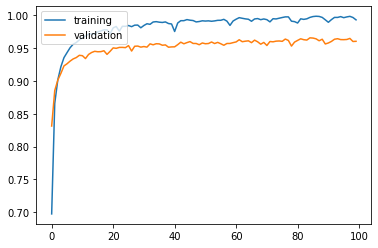

In [4]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [5]:
result = model.evaluate(x_test, y_test)
print(result)

313/313 [==============================] - 0s 644us/step - loss: 0.3482 - accuracy: 0.9643
[0.34821102023124695, 0.9642999768257141]


# 模型儲存  
ref: https://blog.csdn.net/qq_27825451/article/details/105505033?fbclid=IwAR3Tzb3l9bI9qfvvsnkeg5MbpNKwNBqBKkbk2bBug_pPVEcgPGxizpdbb4I

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.compat.v1.reset_default_graph()

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape([x_train.shape[0], -1])
x_test = x_test.reshape([x_test.shape[0], -1])
print(x_train.shape, ' ', y_train.shape)
print(x_test.shape, ' ', y_test.shape)

model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(784,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])


#keras.optimizers.Adagrad(learning_rate=0.01)
#keras.optimizers.Adam(learning_rate=0.01)
#keras.optimizers.RMSprop(learning_rate=0.01)

# provide labels as one_hot representation => tf.keras.losses.CategoricalCrossentropy
# provide labels as integers => tf.keras.losses.SparseCategoricalCrossentropy 
model.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])
model.summary()
history = model.fit(x_train, y_train, batch_size=256, epochs=10, validation_split=0.3, verbose=2)
result = model.evaluate(x_test, y_test)
print(result)

(60000, 784)   (60000,)
(10000, 784)   (10000,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 59,210
Trainable params: 59,210
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
165/165 - 0s - loss: 3.2502 - accuracy: 0.7316 - val_loss: 0.8427 - val_accuracy: 0.8461
Epoch 2/10
165/165 - 0s - loss: 0.6186 - accuracy: 0.8730 - val_loss: 0.5537 - val_accuracy: 0.8846
Ep

In [2]:
# save and restore method1: restore as h5 file
model.save('dnn_mnist_model.h5')
new_model = keras.models.load_model('dnn_mnist_model.h5')
new_model.summary()
result = model.evaluate(x_test, y_test)
print(result)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 59,210
Trainable params: 59,210
Non-trainable params: 0
_________________________________________________________________
313/313 [==============================] - 0s 752us/step - loss: 0.2904 - accuracy: 0.9379
[0.2904110848903656, 0.9379000067710876]


In [3]:
# save and restore method2 
model.save('saved_model', save_format='tf')
new_model = keras.models.load_model('saved_model')
new_model.summary()
result = model.evaluate(x_test, y_test)
print(result)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model\assets
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 59,210
Trainable params: 59,210
Non-trainable params: 0
____________________________

In [9]:
# save and restore method3
json_config = model.to_json()
with open('model_config.json', 'w') as json_file:
    json_file.write(json_config)

model.save_weights('dnn_mnist_model2.h5')
 
with open('model_config.json') as json_file:
    json_config = json_file.read()
new_model = keras.models.model_from_json(json_config)
 
new_model.load_weights('dnn_mnist_model2.h5')
new_model.summary()
result = model.evaluate(x_test, y_test)
print(result)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 59,210
Trainable params: 59,210
Non-trainable params: 0
_________________________________________________________________
313/313 [==============================] - 0s 637us/step - loss: 0.2904 - accuracy: 0.9379
[0.2904110848903656, 0.9379000067710876]


In [15]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
tf.compat.v1.reset_default_graph()

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape([x_train.shape[0], -1])
x_test = x_test.reshape([x_test.shape[0], -1])
print(x_train.shape, ' ', y_train.shape)
print(x_test.shape, ' ', y_test.shape)

model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(784,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])


#keras.optimizers.Adagrad(learning_rate=0.01)
#keras.optimizers.Adam(learning_rate=0.01)
#keras.optimizers.RMSprop(learning_rate=0.01)

# provide labels as one_hot representation => tf.keras.losses.CategoricalCrossentropy
# provide labels as integers => tf.keras.losses.SparseCategoricalCrossentropy 
model.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])
model.summary()

checkpoint = ModelCheckpoint('saved_model2', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

history = model.fit(x_train, y_train, batch_size=256, epochs=10, validation_split=0.3, verbose=2, callbacks=[checkpoint])
result = model.evaluate(x_test, y_test)


(60000, 784)   (60000,)
(10000, 784)   (10000,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 59,210
Trainable params: 59,210
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10

Epoch 00001: val_accuracy improved from -inf to 0.84267, saving model to saved_model2
INFO:tensorflow:Assets written to: saved_model2\assets
165/165 - 1s - loss: 3.1228 - accuracy: 0.7300 - 